### Библиотеки и модули

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel, f_regression
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures

pd.set_option('display.max_columns', 100)
%matplotlib inline

# kNN своими руками (4)

Реализуйте взвешенный алгоритм kNN для регрессии. Пусть нам нужно вычислить значение $y$ для некоторого $x$ при известных данных $\left(x_1, y_1\right), \ldots, \left(x_\ell, y_\ell\right)$. Предсказанием вашего регрессора будет являться

$$
\hat{y} = \frac{\sum\limits_{i=1}^kw_iy_{(i)}}{\sum\limits_{i=1}^kw_i},
$$
где $\left(x_{(1)}, y_{(1)}\right), \ldots, \left(x_{(k)}, y_{(k)}\right)$ - ближайшие $k$ объектов к $x$ по некоторой метрике $d(\cdot, \cdot)$, а $w_i = \frac{1}{d\left(x, x_{(i)}\right)}$. Ваш алгоритм должен уметь работать с двумя метриками:

$$
d\left(x_{(i)}, x\right) = \|x_{(i)} - x\|_2 = \sqrt{\sum\limits_{j=1}^n\left(x_{(i)}^j - x^j\right)^2}\qquad\text{(евклидова)}
$$
$$
d\left(x_{(i)}, x\right) = \|x_{(i)} - x\|_1 = \sum\limits_{j=1}^n\left|x_{(i)}^j - x^j\right|\qquad\text{(манхэттена)}
$$

Сверьте для нескольких комбинаций различных параметров свой результат на искусственной выборке с результатом соответствующего алгоритма из `sklearn` по метрике качества MSE.

In [125]:
class KNN:
    def __init__(self, metric='euclid', k=5):
        """
        PARAMETERS:
        metric ('euclid' or 'manhattan')
        k - number of nearest neighbors
        """
        
        self.metric = metric
        self.k = k
        
        self.X_train = None
        self.y_train = None
        
        
    def fit(self, X_train, y_train):
        """
        INPUT:
        X_train - np.array of shape (l, d)
        y_train - np.array of shape (l,)
        """
        self.X_train = X_train
        self.y_train = y_train
        
        return self
        
    def predict(self, X_test):
        """
        INPUT:
        X_test - np.array of shape (m, d)
        
        OUTPUT:
        y_pred - np.array of shape (m,)
        """
        y_pred = []
        
        if self.metric == 'minkowski': # случай если p=2 - евклидово расстояние
            for x_test in X_test:
                
                store_distances = {}
                sigma_numerator = 0
                sigma_denominator = 0
                
                for i in range(len(X_train)):
                    sigma = 0
                    for j in range(len(X_train[i])):
                        sigma += (X_train[i][j] - x_test[j]) ** 2
                    distance_between_i_and_x_test = np.sqrt(sigma)
                    store_distances[i] = distance_between_i_and_x_test                    

                list_distances = list(store_distances.items())
                list_distances.sort(key=lambda x: x[1], reverse=False)
                k_distances = list_distances[:self.k]
                
                for num_object in k_distances:
                    sigma_numerator += (1 / num_object[1]) * y_train[num_object[0]]
                    sigma_denominator += (1 / num_object[1])
                y_pred.append(sigma_numerator / sigma_denominator)
                                
        elif self.metric == 'manhattan':
            for x_test in X_test:
                
                store_distances = {}
                sigma_numerator = 0
                sigma_denominator = 0
                
                for i in range(len(X_train)):
                    sigma = 0
                    for j in range(len(X_train[i])):
                        sigma += abs(X_train[i][j] - x_test[j])
                    distance_between_i_and_x_test = np.sqrt(sigma)
                    store_distances[i] = distance_between_i_and_x_test                    

                list_distances = list(store_distances.items())
                list_distances.sort(key=lambda x: x[1], reverse=False)
                k_distances = list_distances[:self.k]
                
                for num_object in k_distances:
                    sigma_numerator += (1 / num_object[1]) * y_train[num_object[0]]
                    sigma_denominator += (1 / num_object[1])
                y_pred.append(sigma_numerator / sigma_denominator)
                
        return np.array(y_pred)

In [7]:
np.random.seed(17032019)
X_train = np.random.randn(1000, 50)
y_train = np.random.randn(1000,)
X_test = np.random.randn(500, 50)
y_test = np.random.randn(500,)

In [128]:
metrics = ['manhattan', 'minkowski']
for metric in metrics:
    knn = KNN(metric=metric)
    knn_model = knn.fit(X_train, y_train)
    y_pred = knn_model.predict(X_test)
    
    knn_sklearn = KNeighborsRegressor(n_neighbors=5, metric=metric)
    knn_sklearn_model = knn_sklearn.fit(X_train, y_train)
    y_sklearn_pred = knn_sklearn_model.predict(X_test)
    
    print(f'MSE для kNN регресии своими руками с метрикой {metric}: {mean_squared_error(y_test, y_pred)}')
    print(f'MSE для kNN регресии sklearn с метрикой {metric}: {mean_squared_error(y_test, y_sklearn_pred)}' )

MSE для kNN регресии своими руками с метрикой manhattan: 1.1774034460027114
MSE для kNN регресии sklearn с метрикой manhattan: 1.1781020576821544
MSE для kNN регресии своими руками с метрикой minkowski: 1.143364989935662
MSE для kNN регресии sklearn с метрикой minkowski: 1.143019350619603


# Линейная регрессия своими руками (4)

Реализуйте линейную регрессию с градиентным спуском для [функции потерь Хьюбера](https://en.wikipedia.org/wiki/Huber_loss):

$$
L_\delta\left(y, \hat{y}\right) =
\begin{cases}
\frac{1}{2}\left(y - \hat{y}\right)^2, \qquad &|y - \hat{y}| \leq \delta\\
\delta\left|y - \hat{y}\right| - \frac{1}{2}\delta^2,\qquad & \text{otherwise}
\end{cases}
$$

В таком случае общее значение функции потерь на всем датасете $(x_1, y_1), \ldots, (x_\ell, y_\ell)$ будет равно

$$
L = \frac{1}{\ell}\sum\limits_{i=1}^\ell L_\delta\left(y_i, \hat{y}_i\right)
$$

Проверьте работу вашего метода: выведите результаты его работы на той же искусственной выборке, что и в задаче выше (в качестве метрик качества используйте MSE и Huber loss). Постройте график зависимости значения функции потерь от итерации градиентного спуска.

*Вы можете опустить единичный признак в модели и не добавлять его в данные. Для данной искусственной выборки это не актуально, потому что целевая переменная в этом случае является случайной величиной из стандартного нормального распределения со средним 0.*

*Вектор весов в градиентном спуске можете инициализировать нулями.*

In [5]:
class LinearRegressionHuber:
    def __init__(self, delta=1.0, max_iter=1000, tol=1e-6, eta=1e-2):
        """
        PARAMETERS:
        delta - scalar in Huber loss
        max_iter - maximum possible number of iterations in Gradient Descent
        tol - precision for stopping criterion in Gradient Descent
        eta - step size in Gradient Descent
        """
        
        self.delta = delta
        self.max_iter = max_iter
        self.tol = tol
        self.eta = eta
        
        self.w = None
        self.loss_history = None
        
    def fit(self, X_train, y_train):
        """
        INPUT:
        X_train - np.array of shape (l, d)
        y_train - np.array of shape (l,)
        """
        self.w = np.zeros(X_train.shape[1], )
        self.loss_history = []
        
        for iteration in range(self.max_iter):
            w_store = self.w
            self.w = self.w - self.eta * self.calc_gradient(X_train, y_train)
            self.loss_history.append(self.calc_loss(X_train, y_train))
            if np.linalg.norm(w_store - self.w) < self.tol:
                break
                
        return self.loss_history
        
    def predict(self, X_test):
        """
        INPUT:
        X_test - np.array of shape (m, d)
        
        OUTPUT:
        y_pred - np.array of shape (m,)
        """
        y_pred = X_test.dot(self.w)
        
        return y_pred
    
    def calc_gradient(self, X, y):
        """
        Calculates the gradient of Huber loss by weights.
        
        INPUT:
        X - np.array of shape (l, d)
        y - np.array of shape (l,)
        
        OUTPUT:
        grad - np.array of shape (d,)
        """
        grad = np.zeros(X.shape[1], )
        
        for x_i in range(len(X)):
            y_pred = np.sum(X[x_i].dot(self.w))
            if abs(y_pred - y[x_i]) < self.delta:
                grad_i = []
                for i in range(len(X[x_i])):
                    grad_i.append(X[x_i][i] * (y_pred - y[x_i]))
                grad_i = np.array(grad_i)
            else:
                grad_i = []
                if y_pred > y[x_i]:
                    for i in X[x_i]:
                        grad_i.append(i * self.delta)
                    grad_i = np.array(grad_i)
                else:
                    for i in X[x_i]:
                        grad_i.append(-1 * self.delta * i)
                    grad_i = np.array(grad_i)
            grad += grad_i
            
        grad = grad / X.shape[0]
        
        return grad
            
    
    def calc_loss(self, X, y):
        """
        Calculates the Huber loss.
        
        INPUT:
        X - np.array of shape (l, d)
        y - np.array of shape (l,)
        
        OUTPUT:
        loss - float
        """
        
        loss = 0
        for x_i in range(len(X)):
            y_pred = np.sum(X[x_i].dot(self.w))
            if abs(y_pred - y[x_i]) < self.delta:
                loss += (0.5 * (y_pred - y[x_i]) ** 2)
            else:
                loss += self.delta * abs(y_pred - y[x_i]) - 1/2 * self.delta ** 2
        
        loss /= X.shape[0]
        
        return loss

In [9]:
lrh = LinearRegressionHuber()
lr = LinearRegression()
model_lrh = lrh.fit(X_train, y_train)
model_lr = lr.fit(X_train, y_train)

In [246]:
y_lrh_pred = lrh.predict(X_test)
y_sklearn_pred = lr.predict(X_test)

print(f'MSE для линейной регрессии своими руками: {mean_squared_error(y_lrh_pred, y_test)}')
print(f'MSE для линейной регрессии sklearn: {mean_squared_error(y_sklearn_pred, y_test)}')

MSE для линейной регрессии своими руками: 1.091952430747943
MSE для линейной регрессии sklearn: 1.0882539618811702


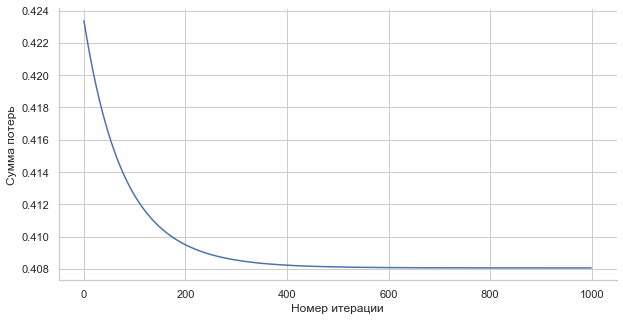

In [245]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(range(1000), model_lrh)
sns.despine()
plt.xlabel('Номер итерации')
plt.ylabel('Сумма потерь')
plt.show()

# Практика

В этом домашнем задании вы поработаете с данными из другого соревнования на Kaggle: https://www.kaggle.com/c/house-prices-advanced-regression-techniques. Задача - предсказание цены дома.

In [3]:
data = pd.read_csv('train.csv', header=0)

In [4]:
data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [5]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
data.drop('Id', axis=1, inplace=True)
data.head(1)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500


In [7]:
data.shape

(1460, 80)

## 1 (1)

Есть ли в данных пропуски? Если да, то для каждого столбца, в котором они имеются, посчитайте их количество и их долю от общего числа значений. Что вы наблюдаете?

Количество пропусков

In [8]:
data.isnull().sum().sort_values(ascending=False).head(20)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageCond        81
GarageFinish      81
GarageQual        81
GarageYrBlt       81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
MasVnrType         8
Electrical         1
RoofMatl           0
dtype: int64

In [9]:
((data.isnull().sum() / data.shape[0]) * 100).sort_values(ascending=False).head(20)

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageType       5.547945
GarageCond       5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageYrBlt      5.547945
BsmtFinType2     2.602740
BsmtExposure     2.602740
BsmtQual         2.534247
BsmtCond         2.534247
BsmtFinType1     2.534247
MasVnrArea       0.547945
MasVnrType       0.547945
Electrical       0.068493
RoofMatl         0.000000
dtype: float64

Есть объекты, у которых пропущено более 15% данных. Могу сделать предположение, что это одни и те же объекты, у которых пропущены значения в признаках, связанных с гаражом. Аналогичную ситуацию наблюдаем с признаком Bsmt_. И около 1 процента объектов, у которых пропущены значения в других столбцах.

## 2 (1)

Избавьтесь от пропусков. Для каждого из примененных методов обоснуйте свое решение. **Проверьте, что вы действительно избавились от пропусков.**

*Напоминание. В зависимости от типа столбца, можно заполнить пропуски, например, средним арифметическим, медианой, модой, можно какими-то отдельными значениями. А можно такие столбцы вообще удалить.*

Столбцы PoolQC, MiscFeature, Alley и Fence содержат более 80% пропущенных значений. Из-за наличия большого количества пропусков в этих столбцах удалим их.

In [10]:
data.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence'], axis=1, inplace=True)

Выделяют три вида пропусков:
- MCAR - абсолютно случайные пропуски, вероятность появления которых одинакова для каждой записи набора данных.
- MAR - случайные пропуски, вероятность появления которых зависит от другой информации в данных.
- MNAR - неслучайные пропуски, вероятность появления которых зависит от другой информации в данных, при этом информация по этим атрибутам может отсутствовать.

Также пропуски разделяют по причине технологической и вызванной человеческим фактором.

Заполним пропуски в столбце LotFrontage медианным значением, а в столбце FireplaceQu - модой. В столбцах, в которых содержится информация о гараже и в которых пропущены значения, вероятнее все то, что у этих домов просто нет гаражей, поэтому информация и пропущена в данных объектах о них. Заметим, что восстановить год постройки гаража мы не можем никак, а исключение его из анализа не скажется на результате. Остается около 2.6% объектов с пропусками. Удаление их из анализа сильно на результатах моделей не скажется.

In [11]:
# data.loc[data['LotFrontage'].isnull() == True, 'LotFrontage'] = data['LotFrontage'].median()
# data.loc[data['FireplaceQu'].isnull() == True, 'FireplaceQu'] = data['FireplaceQu'].mode()[0]
# data.loc[data['GarageType'].isnull() == True, 'GarageType'] = 'none'
# data.loc[data['GarageCond'].isnull() == True, 'GarageCond'] = 'none'
# data.loc[data['GarageFinish'].isnull() == True, 'GarageFinish'] = 'none'
# data.loc[data['GarageQual'].isnull() == True, 'GarageQual'] = 'none'
# data.drop('GarageYrBlt', axis=1, inplace=True)
# data.dropna(inplace=True)

<div style="border:solid dark blue 2px; padding: 20px"> <h1 style="color:dark blue; margin-bottom:20px">Комментарий</h1>
В закомментированной выше ячейке изначально я предобработал данные таким образом. Однако в ходе изучения корреляций между признаками и ключевой переменной я заметил, что данные признаки имеют низкую корреляцию с ценой, поэтому удаляю данные признаки, чтобы не терять другой важной информации об объектах. Я так делаю, чтобы не производить повторных преобразований данных заново, с целю улучшения метрики качества модели. При таком способе обработки данных пропусков получаю более выскоие метрики качества моделей. Прошу не снимать балл за этого задание (так делаю только для удобства работы).

In [12]:
data_isnull = data.isnull().sum()
data_isnull = data_isnull[data_isnull > 0].index.tolist()
data_isnull
data.drop(data_isnull, inplace=True, axis=1)

In [13]:
((data.isnull().sum() / data.shape[0]) * 100).sort_values(ascending=False).head(15)

SalePrice       0.0
Heating         0.0
BsmtUnfSF       0.0
BsmtFinSF2      0.0
BsmtFinSF1      0.0
Foundation      0.0
ExterCond       0.0
ExterQual       0.0
Exterior2nd     0.0
Exterior1st     0.0
RoofMatl        0.0
RoofStyle       0.0
YearRemodAdd    0.0
YearBuilt       0.0
OverallCond     0.0
dtype: float64

## 3 (1)

Обработайте категориальные признаки. В их обнаружении вам может помочь синтаксис `pandas` (например, можно обратить внимание на типы столбцов), а также описание датасета и его исследование. Объясните выбор метода (one-hot-encoding, label encoding, ...)

Для удобства работы с данными создадим маску для категориальных переменных.

In [14]:
data_feature_mask = (data.dtypes == 'object').values

In [15]:
data_cat = data[data.columns[data_feature_mask]]
data_cat.head(5)

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,ExterQual,ExterCond,Foundation,Heating,HeatingQC,CentralAir,KitchenQual,Functional,PavedDrive,SaleType,SaleCondition
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,Gd,TA,PConc,GasA,Ex,Y,Gd,Typ,Y,WD,Normal
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,TA,TA,CBlock,GasA,Ex,Y,TA,Typ,Y,WD,Normal
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,Gd,TA,PConc,GasA,Ex,Y,Gd,Typ,Y,WD,Normal
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,TA,TA,BrkTil,GasA,Gd,Y,Gd,Typ,Y,WD,Abnorml
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,Gd,TA,PConc,GasA,Ex,Y,Gd,Typ,Y,WD,Normal


При использовании one-hot-encoding методов важно понять для начала, что кодируемый таким образом признак не содержит в себе хотя бы более 50% уникальных значений в себе, иначе смысла в его кодировании не будет, а память хранения данных только от этого возрастет.

In [16]:
cat_columns = data_cat.columns.tolist()
cat_one_hot = []
for cat in cat_columns:
    if len(data_cat[cat].unique()) / len(data_cat[cat]) < 0.5:
        cat_one_hot.append(cat)
    else:
        print(f'Столбец {cat} не кодируем методами one-hot-encoding')

print(cat_one_hot == cat_columns)

True


Получаем, что все столбцы обработаем с помощью метода one-hot-encoding.

In [17]:
data = pd.get_dummies(data, drop_first=True)
data.head(5)

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSeWa,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,...,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,PavedDrive_P,PavedDrive_Y,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,8450,7,5,2003,2003,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2,548,0,61,0,0,0,0,0,2,2008,208500,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,...,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
1,20,9600,6,8,1976,1976,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,2,460,298,0,0,0,0,0,0,5,2007,181500,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
2,60,11250,7,5,2001,2002,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2,608,0,42,0,0,0,0,0,9,2008,223500,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,...,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
3,70,9550,7,5,1915,1970,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,3,642,0,35,272,0,0,0,0,2,2006,140000,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
4,60,14260,8,5,2000,2000,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,3,836,192,84,0,0,0,0,0,12,2008,250000,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0


In [18]:
data.dtypes

MSSubClass               int64
LotArea                  int64
OverallQual              int64
OverallCond              int64
YearBuilt                int64
                         ...  
SaleCondition_AdjLand    uint8
SaleCondition_Alloca     uint8
SaleCondition_Family     uint8
SaleCondition_Normal     uint8
SaleCondition_Partial    uint8
Length: 189, dtype: object

## 4 (0.5)

Вычислите и визуализируйте попарную корреляцию Пирсона между всеми признаками. Какие выводы можно сделать?

*Для визуализации можно использовать `seaborn.heatmap()`.*

In [418]:
data.corr() # Вычисляю попарную корреляцию Пирсона

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSeWa,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,...,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,PavedDrive_P,PavedDrive_Y,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
MSSubClass,1.000000,-0.139781,0.032628,-0.059316,0.027850,0.040581,-0.069836,-0.065649,-0.140759,-0.238518,-0.251758,0.307886,0.046474,0.074853,0.003491,-0.002333,0.131608,0.177354,-0.023438,0.281721,0.040380,-0.045569,-0.040110,-0.098672,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284,0.171336,0.058288,-0.343353,0.277750,-0.024969,-0.019392,-0.031221,0.122030,-0.010676,-0.032201,0.010845,-0.022844,-0.044437,0.015217,0.044130,0.067828,...,-0.010328,-0.074141,-0.073189,0.029798,0.027165,0.047870,-0.041021,0.072853,-0.044651,-0.016653,0.012015,-0.087346,0.071000,0.019040,0.032564,-0.003824,-0.048044,0.047096,0.006265,0.013666,0.028636,0.002431,-0.003806,-0.007366,0.021455,-0.101774,0.016676,0.022411,-0.010836,-0.034515,-0.038631,-0.014446,0.004263,0.001921,0.014090,-0.025338,-0.047611,0.028636,0.028994,0.085451,-0.001244,0.014005,-0.045156,-0.014555,0.026359,0.016241,0.030002,0.000983,0.024359,-0.051068
LotArea,-0.139781,1.000000,0.105806,-0.005636,0.014228,0.013788,0.214103,0.111170,-0.002618,0.260833,0.299475,0.050986,0.004779,0.263116,0.158155,0.048046,0.126031,0.014259,0.119690,-0.017784,0.190015,0.271364,0.154871,0.180403,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843,-0.083895,-0.033092,0.204065,-0.173709,-0.197131,0.225160,0.256526,-0.216111,0.089605,0.359475,-0.256843,0.010123,0.179440,-0.002167,-0.009511,-0.132773,...,0.016712,-0.040478,0.008122,-0.007627,-0.021622,0.003151,-0.027890,-0.028664,0.001327,-0.013557,0.011682,0.066340,-0.033727,-0.018129,-0.009671,0.008896,-0.079682,0.127918,-0.016126,-0.011477,-0.012311,-0.013661,-0.013072,-0.014475,0.011328,0.049755,-0.033694,0.004941,-0.031154,-0.009691,0.029287,0.010409,0.043304,0.020815,-0.036048,0.012568,0.010431,-0.007818,-0.002872,-0.006018,0.001076,-0.015040,0.020039,-0.005722,-0.002292,-0.013208,0.008966,-0.010781,0.005711,0.022635
OverallQual,0.032628,0.105806,1.000000,-0.091932,0.572323,0.550684,0.239666,-0.059119,0.308159,0.537808,0.476224,0.295493,-0.030429,0.593007,0.111098,-0.040150,0.550600,0.273458,0.101676,-0.183882,0.427452,0.396765,0.600671,0.562022,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982,0.171854,-0.064666,0.126972,-0.195515,0.058823,0.077753,0.042089,-0.199335,0.103611,-0.046563,0.017672,-0.001881,0.076027,0.012159,0.043625,-0.044691,...,-0.028403,0.352152,-0.158878,-0.002408,-0.164663,0.547731,-0.646247,-0.150923,-0.075139,-0.058690,0.131245,-0.429761,0.568211,-0.169032,-0.020103,0.018621,0.112264,-0.039453,-0.091051,0.024129,-0.098545,-0.148178,-0.128025,-0.020817,-0.

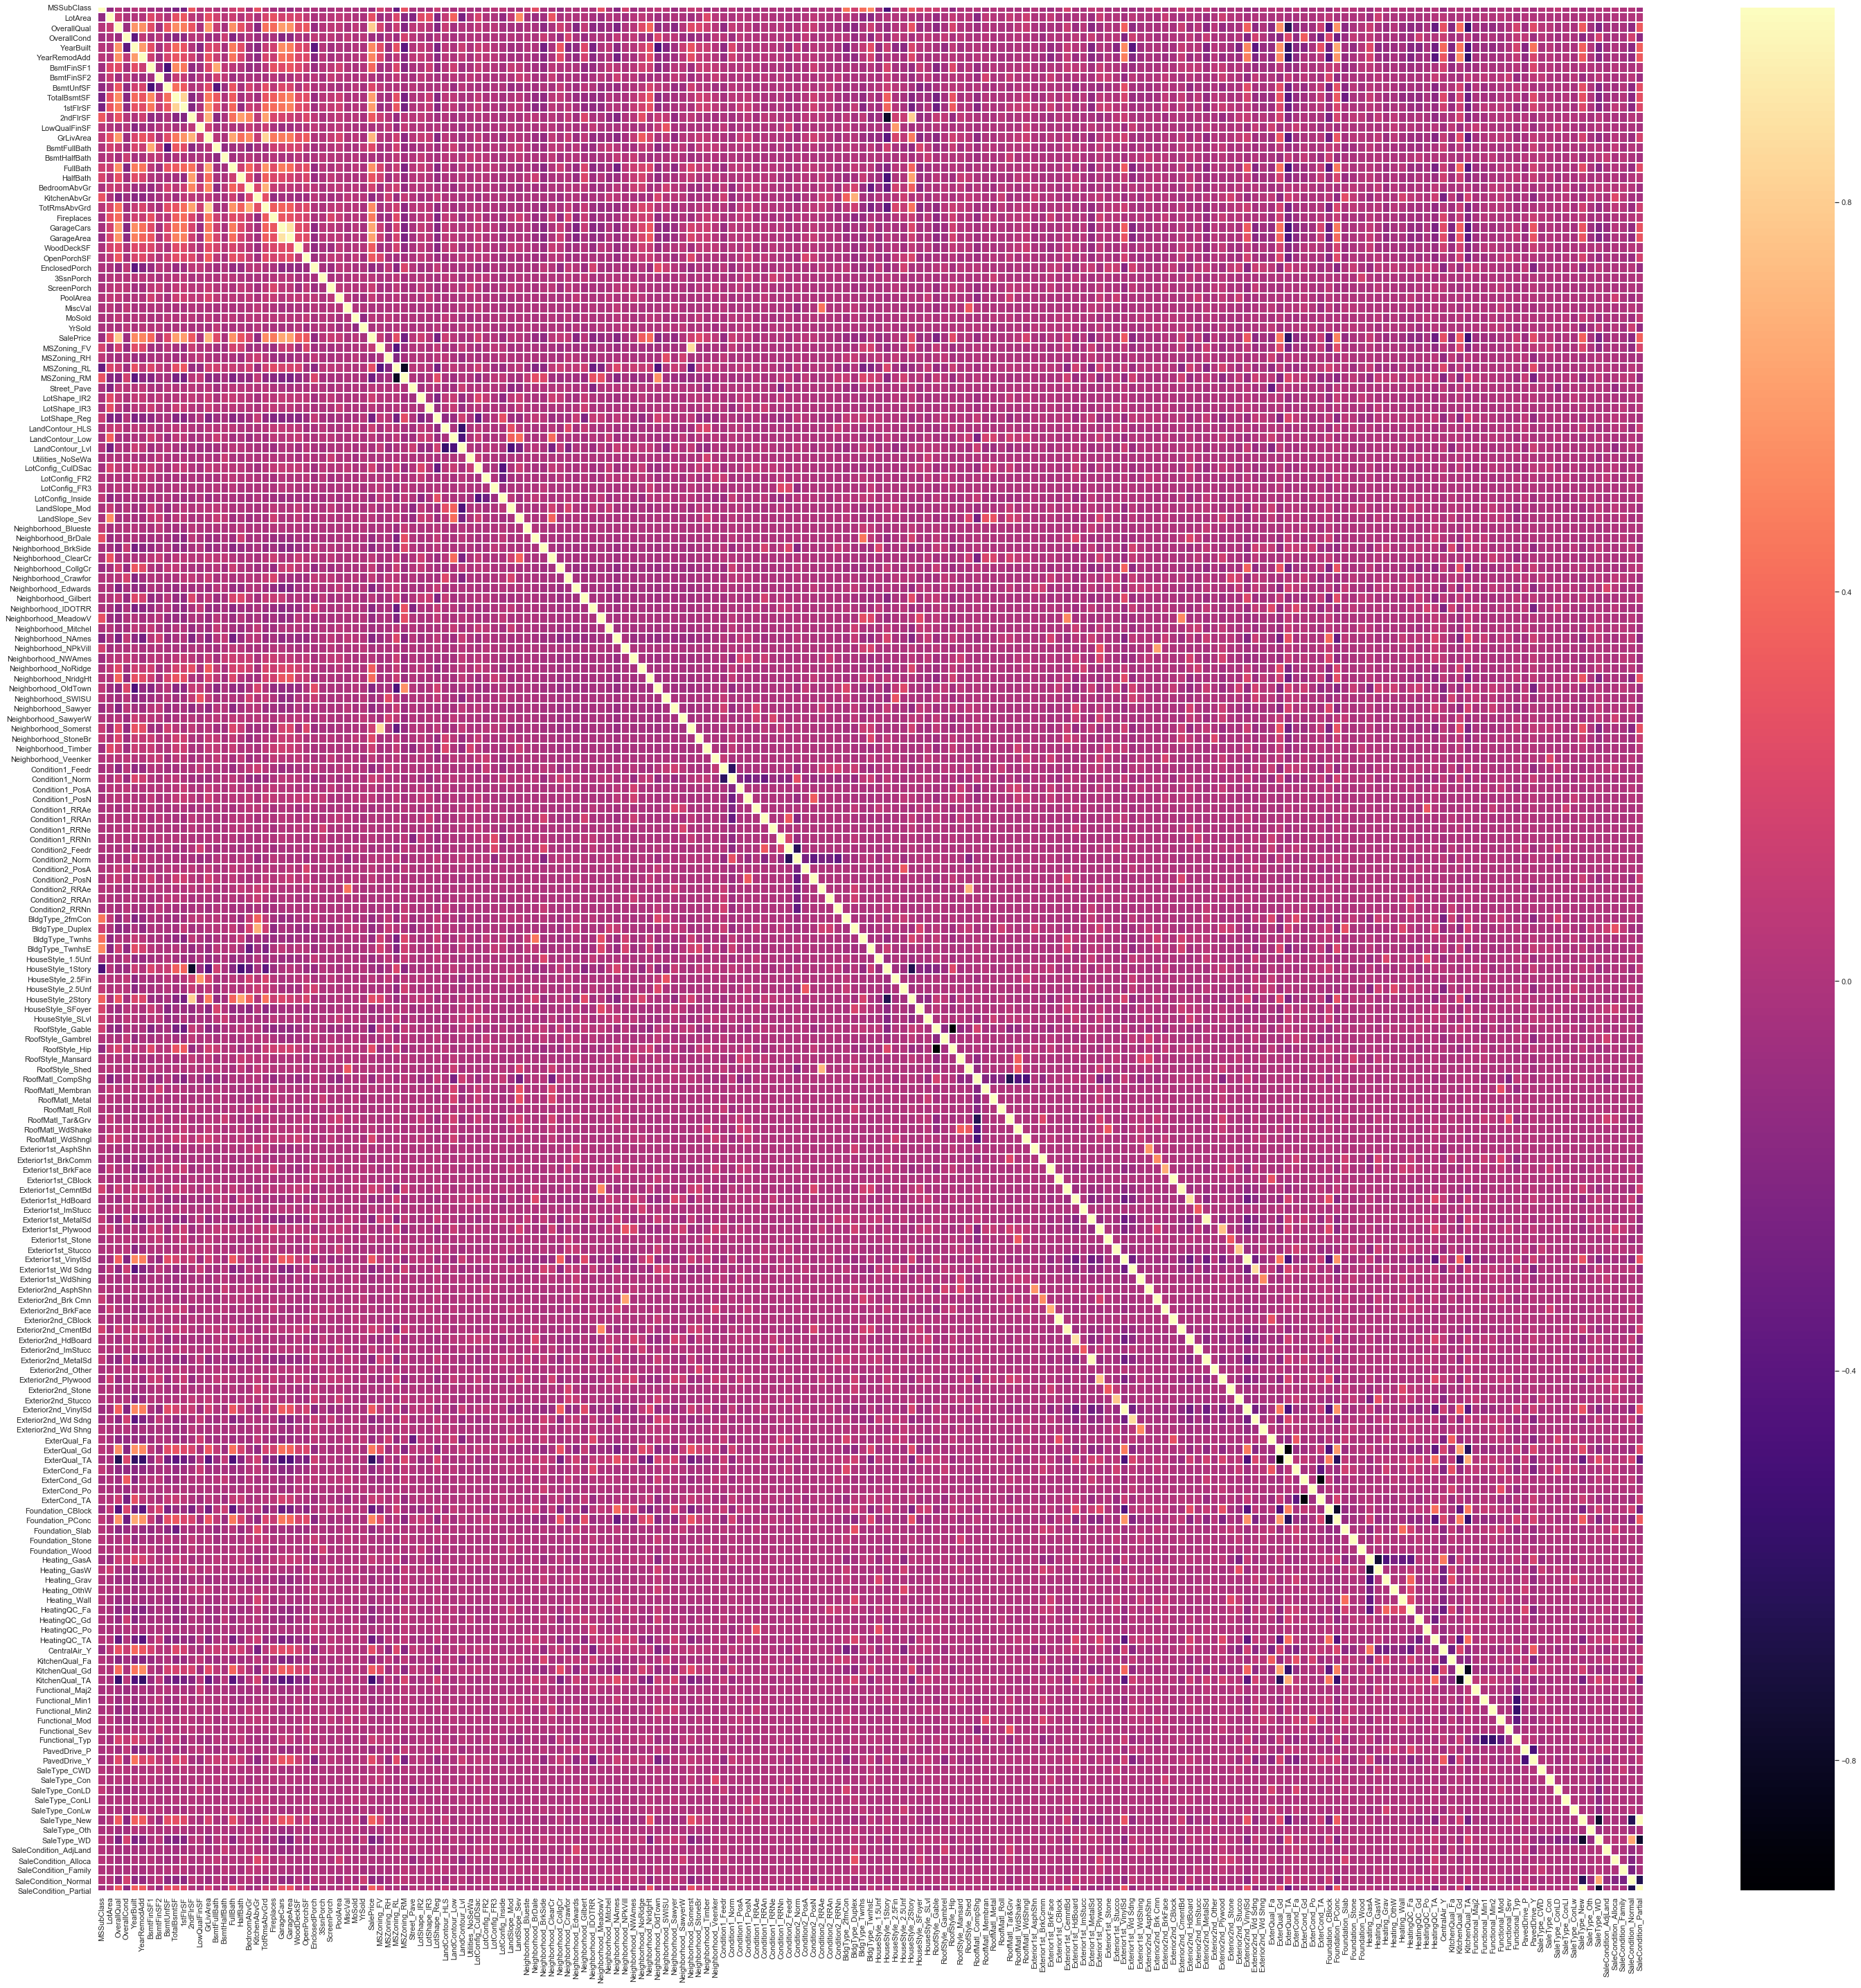

In [419]:
fig, ax = plt.subplots(figsize=(50, 50))
sns.heatmap(data.corr(), cmap='magma', linewidths=1)
plt.show()

Вывод: признаков слишком много, что очень сложно сказать о какой-либо корреляции между признаками, поэтому необходимо отобрать те признаки, которые коррелирует больше всего с ключевой переменной.

## 5 (0.5)

Найдите признаки с максимальным и минимальным **абсолютным** значением коэффициента корреляции Пирсона с предсказываемым значением. Изобразите на графиках зависимость найденных признаков от предсказываемого значения.

*Не забудьте указать название графика и обозначить, что изображено по каждой из осей.*

In [420]:
corr_price = abs(data.corr()['SalePrice']).sort_values(ascending=False)
corr = corr_price.drop(['SalePrice'], axis=0)
corr.head(10)

OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
ExterQual_TA    0.589044
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64

In [421]:
max_corr_feature = corr.head(1).index.tolist()[0]
print(f'Признаком, обладающим максимальной корреляцией является: {max_corr_feature}')

Признаком, обладающим максимальной корреляцией является: OverallQual


In [422]:
min_corr_feature = corr.tail(1).index.tolist()[0]
print(f'Признаком, обладающим минимальной корреляцией является: {min_corr_feature}')

Признаком, обладающим минимальной корреляцией является: RoofMatl_Metal


In [423]:
min_max_corr_data = data[[max_corr_feature, min_corr_feature, 'SalePrice']]

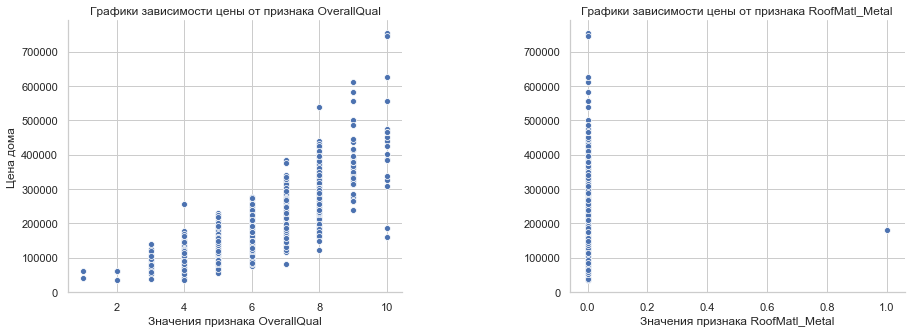

In [424]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
sns.set(style='whitegrid')
sns.scatterplot(data=min_max_corr_data, x=max_corr_feature, y='SalePrice', ax=ax[0])
sns.scatterplot(data=min_max_corr_data, x=min_corr_feature, y='SalePrice', ax=ax[1])
sns.despine()
ax[0].set_title(f'Графики зависимости цены от признака {max_corr_feature}')
ax[1].set_title(f'Графики зависимости цены от признака {min_corr_feature}')
ax[0].set_xlabel(f'Значения признака {max_corr_feature}')
ax[1].set_xlabel(f'Значения признака {min_corr_feature}')
ax[0].set_ylabel('Цена дома')
ax[1].set_ylabel('')
plt.subplots_adjust(wspace=0.5, hspace=0)
plt.show()

## 6 (0.5)

Постройте гистограмму распределения предсказываемого значения. Для избавления от разницы в масштабах, а также «смещения» распределения переменной в сторону нормального (что бывает полезно при статистическом анализе), можно прологарифмировать ее (это обратимое преобразование, поэтому целевую переменную легко восстановить). В данном случае воспользуйтесь `numpy.log1p`, чтобы сделать преобразование $y \to \ln\left(1 + y\right)$. Постройте гистограмму распределения от нового предсказываемого значения. Опишите наблюдения.

*В дальнейшем используйте в качестве предсказываемого значения вектор, который получился после логарифмирования.*

In [425]:
data['price'] = np.log1p(data['SalePrice'])

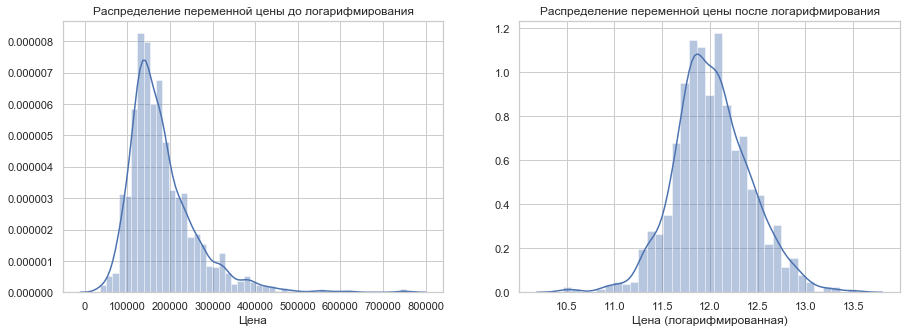

In [426]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
sns.distplot(data['SalePrice'], ax=ax[0])
sns.distplot(data['price'], ax=ax[1])
ax[0].set_title('Распределение переменной цены до логарифмирования')
ax[1].set_title('Распределение переменной цены после логарифмирования')
ax[0].set_xlabel('Цена')
ax[1].set_xlabel('Цена (логарифмированная)')
plt.show()

In [427]:
features = corr.index.tolist()
X = data[features]
y = data['price']

In [428]:
# Filter Method

features = corr[corr >= 0.05].index.tolist()

Также необходимо масштабировать признаки для того, чтобы:
- модель обучалась быстрее;
- улучшение численной устойчивости при работе с матрицей объекты-признаки;
- для интерпретации весов при признаках как меры значимости

In [429]:
X = data[features]
y = data['price']

for feature in features:
    X[feature] = np.log1p(X[feature])

normilizer = MinMaxScaler()
X_norm = normilizer.fit_transform(X)
X = pd.DataFrame(data=X_norm)

C:\Users\kiril\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Перейдем непосредственно к построению моделей. Разобьем выборку на обучение и контроль.

*Пожалуйста, **не меняйте** значение `random_state` в следующей ячейке.*

In [431]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=17032019, test_size=0.1)

In [432]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1314, 111), (146, 111), (1314,), (146,))

## 7 (2)

Примените к данным следующие алгоритмы:

- kNN
- линейная регрессия
- Lasso
- Ridge

Для каждого из методов подберите гиперпараметры с помощью кросс-валидации. Обучите алгоритмы с лучшими гиперпараметрами на обучающей выборке и оцените качество по метрике **Root** Mean Squared Error. Какой из методов показывает себя лучше?

#### kNN

In [433]:
gs_knn = GridSearchCV(
    KNeighborsRegressor(),
    param_grid={
        'n_neighbors': range(1, 40, 2),
        'weights': ['uniform', 'distance'],
        'p': [1, 2, 3],
        'n_jobs': [-1],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    },
    cv=10
)

In [286]:
gs_knn.fit(X_train, y_train) # тренируем модель
print(f'Лучшие параметры, найденные при использовании кросс-валидации: {gs_knn.best_params_}')
best_predictions = gs_knn.predict(X_val) # предсказываем цену на валидационной выборке
print(f'RMSE: {np.sqrt(mean_squared_error(y_val, best_predictions))}') # считаем метрику MSE для данной модели

Лучшие параметры, найденные при использовании кросс-валидации: {'algorithm': 'auto', 'n_jobs': -1, 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
RMSE: 0.17924714234365371


#### Линейная регрессия

In [434]:
gs_lr = GridSearchCV(
    LinearRegression(),
    param_grid={},
    cv=10
) # не ясно то, какие параметры могут подбираться для данной модели, поэтому указано только n_jobs = -1

In [435]:
gs_lr.fit(X_train, y_train) # тренируем модель
print(f'Лучшие параметры, найденные при использовании кросс-валидации: {gs_lr.best_params_}')
best_predictions = gs_lr.predict(X_val) # предсказываем цену на валидационной выборке
print(f'RMSE: {np.sqrt(mean_squared_error(y_val, best_predictions))}') # считаем метрику MSE для данной модели

Лучшие параметры, найденные при использовании кросс-валидации: {}
RMSE: 0.12044700592292053


#### Lasso

In [436]:
gs_lasso = LassoCV(cv=10)

In [437]:
gs_lasso.fit(X_train, y_train) # тренируем модель
# print(f'Лучшие параметры, найденные при использовании кросс-валидации: {gs_lasso.best_params_}')
best_predictions = gs_lasso.predict(X_val) # предсказываем цену на валидационной выборке
print(f'RMSE: {np.sqrt(mean_squared_error(y_val, best_predictions))}') # считаем метрику MSE для данной модели

RMSE: 0.11825760477705129


#### Ridge

In [438]:
gs_ridge = RidgeCV(cv=10)

In [439]:
gs_ridge.fit(X_train, y_train) # тренируем модель
# print(f'Лучшие параметры, найденные при использовании кросс-валидации: {gs_ridge.best_params_}')
best_predictions = gs_ridge.predict(X_val) # предсказываем цену на валидационной выборке
print(f'RMSE: {np.sqrt(mean_squared_error(y_val, best_predictions))}') # считаем метрику MSE для данной модели

RMSE: 0.12039029411177542


*Вывод*

Лучше всего себя показывает модель Lasso, так как метрика RMSE у нее наименьшая и равна 0.11825.

## 8 (1)

Постройте гистограммы значений весов для линейной регрессии, Lasso и Ridge. Опишите наблюдения. В чем различия между полученными наборами весов и почему?

In [440]:
lr = LinearRegression()
model_lr = lr.fit(X_train, y_train)

In [441]:
lr_coef = model_lr.coef_
lasso_coef = gs_lasso.coef_
ridge_coef = gs_ridge.coef_

coefs = []
coefs.append([lr_coef, 'LinearRegression'])
coefs.append([lasso_coef, 'Lasso'])
coefs.append([ridge_coef, 'Ridge'])

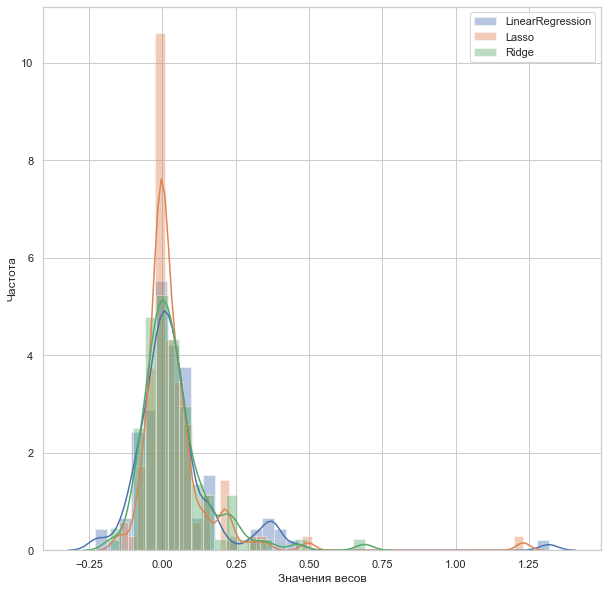

In [442]:
fig, ax = plt.subplots(figsize=(10, 10))
for coef in coefs:
    sns.distplot(coef[0], ax=ax, label=coef[1])
plt.legend()
plt.xlabel('Значения весов')
plt.ylabel('Частота')
plt.show()

И Lasso и Linear Regression оценили какой-то признак высоким значением веса в отличие от Ridge (справа на графике значение веса около 1.25). Также у лассо большое количество признаков, значения весов которых оценены в пределах нуля. Распределения весов у признаков у Ridge и Linear Regression похожи. Можно отметить, что у Linear Regression есть пик распредения в диапазоне 0.25-0.5.

## 9 (0.5)

Добейтесь того, чтобы в заданиях выше ваш лучший алгоритм давал качество не больше 0.125 на тестовых данных по метрике RMSE (если вы дошли до этого задания, а качество выше уже удовлетворяет этому условию, вы автоматически получите за него полный балл).

## 10* (0.5)

Добейтесь того, чтобы в заданиях выше ваш лучший алгоритм давал качество не больше 0.121 на тестовых данных по метрике RMSE. Для этого вы можете использовать самые разные методы, какие захотите - отбор признаков, генерация новых, разные способы предобработки данных. Единственное ограничение - не использовать никакие алгоритмы регрессии, кроме kNN, линейной регрессии, Lasso и Ridge.